In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/india-comments/India political comments.csv


In [2]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel, AdamW
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from sklearn.metrics import confusion_matrix


In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Data Preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)  # Tokenize the text
    stop_words = set(stopwords.words('english'))  # Get English stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    preprocessed_text = ' '.join(filtered_tokens)  # Join tokens back into a string
    return preprocessed_text

In [5]:
# Load data
data = pd.read_csv("/kaggle/input/india-comments/India political comments.csv")

data['tweets'] = data['tweets'].apply(preprocess_text)


In [6]:
data.target.value_counts()

target
1    1563
0    1204
Name: count, dtype: int64

In [7]:
data.shape

(2767, 2)

In [9]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


In [10]:
#!pip install --upgrade transformers



In [11]:
# Initialize tokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [12]:
# Define CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = self.data.tweets.values
        self.targets = self.data.target.values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

# Define Encoder-Decoder model
class EncoderDecoder(nn.Module):
    def __init__(self, num_layers, pretrained_model_name, num_classes, hidden_size):
        super(EncoderDecoder, self).__init__()
        self.encoders = nn.ModuleList([RobertaModel.from_pretrained(pretrained_model_name) for _ in range(num_layers)])
        self.decoders = nn.ModuleList([SentimentDecoder(self.encoders[i].config.hidden_size, hidden_size, num_classes)
                                        for i in range(num_layers)])
        self.drop = nn.Dropout(p=0.3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        pooled_outputs = []
        for encoder in self.encoders:
            output = encoder(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            pooled_outputs.append(output.pooler_output)
        pooled_output = torch.cat(pooled_outputs, dim=1)  # Concatenate pooled outputs from all encoders
        pooled_output = self.drop(pooled_output)  # Apply dropout
        decoder_outputs = []
        for decoder in self.decoders:
            output, _ = decoder(pooled_output.unsqueeze(0), None)  # Pass pooled_output through each decoder
            decoder_outputs.append(output)
        return torch.stack(decoder_outputs).mean(dim=0)  # Average the decoder outputs from all layers


In [13]:
class SentimentDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SentimentDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = torch.log_softmax(self.out(output[0]), dim=1)
        return output, hidden

class StackedTransformer(nn.Module):
    def __init__(self, num_layers, pretrained_model_name, num_classes, hidden_size):
        super(StackedTransformer, self).__init__()
        self.num_layers = num_layers
        self.encoders = nn.ModuleList([RobertaModel.from_pretrained(pretrained_model_name) for _ in range(num_layers)])
        self.decoders = nn.ModuleList([SentimentDecoder(self.encoders[0].config.hidden_size, hidden_size, num_classes) for _ in range(num_layers)])
        self.drop = nn.Dropout(p=0.3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        encoder_outputs = []
        for encoder in self.encoders:
            encoder_output = encoder(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            encoder_outputs.append(encoder_output.pooler_output)
        stacked_encoder_output = torch.stack(encoder_outputs, dim=1)
        
        decoder_outputs = []
        for decoder, encoder_output in zip(self.decoders, stacked_encoder_output.unbind(dim=1)):
            pooled_output = self.drop(encoder_output)
            decoder_output, _ = decoder(pooled_output.unsqueeze(0), None)
            decoder_outputs.append(decoder_output)
        stacked_decoder_output = torch.stack(decoder_outputs, dim=1)
        
        # Combine decoder outputs, e.g., by averaging or concatenation
        final_output = torch.mean(stacked_decoder_output, dim=1)
        
        return final_output.squeeze(0)


In [14]:
# Training parameters
MAX_LEN = 128
BATCH_SIZE = 16
NUM_CLASSES = 2
LEARNING_RATE = 2e-5
EPOCHS = 50
NUM_LAYERS = 4  # Number of encoder-decoder pairs
HIDDEN_SIZE = 512  # Hidden size of each decoder


In [15]:
# Usage
model = StackedTransformer(num_layers=4, pretrained_model_name='roberta-base', num_classes=NUM_CLASSES, hidden_size=512)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['robert

In [16]:
# Move model to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [17]:

# Initialize optimizer and criterion
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:

# Create train and test datasets
train_dataset = CustomDataset(train_data, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(test_data, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [19]:
epoch_nums = []
train_losses = []
train_accuracies = []


In [20]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    avg_epoch_loss = epoch_loss / len(train_loader)
    
    epoch_nums.append(epoch + 1)
    train_losses.append(avg_epoch_loss)
    train_accuracies.append(accuracy)
    
    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss / len(train_loader)}, Accuracy: {accuracy}')


Epoch 1/50, Loss: 0.6379388798055031, Accuracy: 0.6344328965205603
Epoch 2/50, Loss: 0.4391231175592477, Accuracy: 0.7998192498870311
Epoch 3/50, Loss: 0.3434269152206483, Accuracy: 0.850429281518301
Epoch 4/50, Loss: 0.2879030153744941, Accuracy: 0.8874830546769091
Epoch 5/50, Loss: 0.21847746644517502, Accuracy: 0.9191143244464528
Epoch 6/50, Loss: 0.16872772676267211, Accuracy: 0.9421599638499774
Epoch 7/50, Loss: 0.14075195148131617, Accuracy: 0.9502937189335743
Epoch 8/50, Loss: 0.12412783101522665, Accuracy: 0.9602349751468595
Epoch 9/50, Loss: 0.0939105918108345, Accuracy: 0.9688206055128784
Epoch 10/50, Loss: 0.07677572794767806, Accuracy: 0.9760506100316313
Epoch 11/50, Loss: 0.06893569629860492, Accuracy: 0.9751468594667871
Epoch 12/50, Loss: 0.07274230683671323, Accuracy: 0.973791233619521
Epoch 13/50, Loss: 0.04284059003216596, Accuracy: 0.9864437415273385
Epoch 14/50, Loss: 0.024190018217333947, Accuracy: 0.9936737460460913
Epoch 15/50, Loss: 0.033036621285790053, Accuracy

In [21]:
# Evaluation
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device, dtype=torch.long)

        outputs = model(input_ids, attention_mask, token_type_ids)
        
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())



        # Ensure outputs have the expected shape
        if outputs.dim() == 1:
            # Handle the case where outputs might be a single-dimension tensor
            outputs = outputs.unsqueeze(0)  # Add a batch dimension if needed
        
        if outputs.dim() == 2:
            _, predicted = torch.max(outputs, 1)
        else:
            raise ValueError(f'Unexpected output shape: {outputs.shape}')

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy}')
    
# Construct confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.8447653429602888
Confusion Matrix:
[[199  52]
 [ 34 269]]


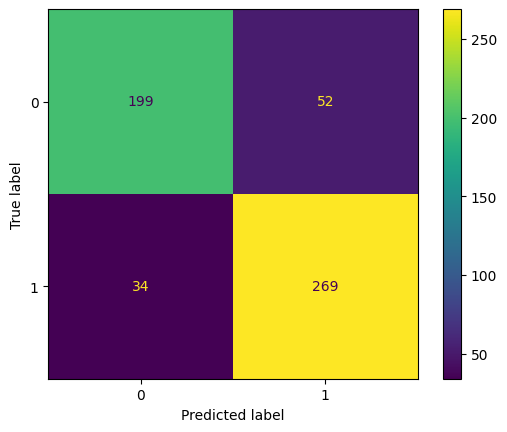

In [22]:
from sklearn import metrics
import matplotlib.pyplot as plt


# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(true_labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()


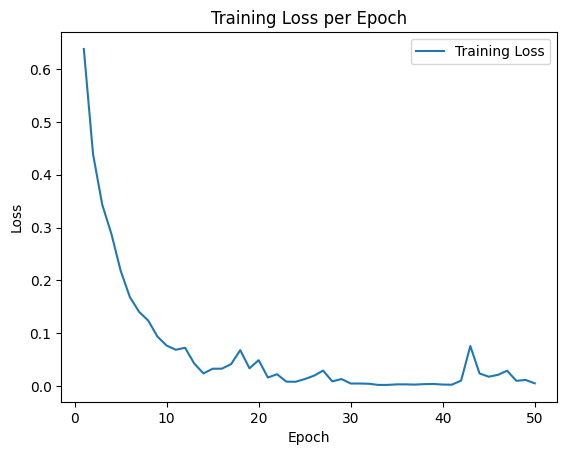

In [23]:
import matplotlib.pyplot as plt

# Plot the epoch and training loss
plt.plot(epoch_nums, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

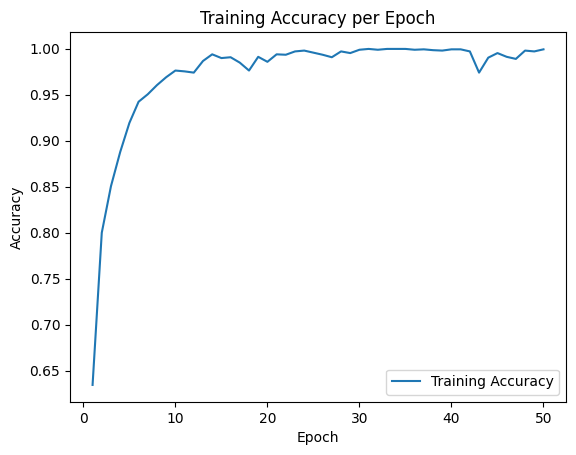

In [24]:

# Plot the training accuracy curve
plt.plot(epoch_nums, train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.show()

In [26]:
# Prediction function remains the same
def predict_sentiment(text, model, tokenizer, max_len):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        input_ids = torch.tensor(inputs['input_ids']).unsqueeze(0).to(device)
        attention_mask = torch.tensor(inputs['attention_mask']).unsqueeze(0).to(device)
        token_type_ids = torch.tensor(inputs["token_type_ids"]).unsqueeze(0).to(device)
        outputs = model(input_ids, attention_mask, token_type_ids)
        
        # Reshape outputs tensor
        outputs = outputs.view(1, -1)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted_index = torch.max(probabilities, 1)
        predicted_label = "Positive" if predicted_index.item() == 1 else "Negative"
        return predicted_label


new_text = [
    "I'm not the smartest guy and i hardly know everything, but i have always been a keen student history and a follower of politics, particularly US politics for 30 years. What is chilling, and believe me i did get the chills while watching this video, is that I 100% agree with his analysis. He vocalized succinctly what has been causing me great anxiety deep down for a long time about US and global politics. An anxiety that has been affecting me in a way it has never affected me before. Too many people underestimate the very real potential threat Trump and his ilk pose to not only US, but also global stability. Quite frankly it is downright frightening. No joke. And all of it is the result of what the state of the U.S. political system, among other things, has been allowed to degrade to over the last few decades. Of course it was never perfect, and there have been many tense global events in the decades since WW2, but now we really are on a real precipice looking over the edge into the abyss like never before. Yes, some might call it 'Trump delusion syndrome', or that i am exaggerating, but honestly, deep down, after much self reflection....i don't think i am. Let's just hope the proverbial coin flip lands right side up, however that needs to play out.",
    "Indian policy consider leader nation representative. Right Biden president represents country. Personal friendships room politics.",
    "This needs to be a criminal offence. As does lying to the public if an MP or a news outlet.",
    "Quite frankly it is downright frightening. No joke.",
    "The people who witnessed the incident told the truth, so others understand that he was innocent.",
    "Is this the right news? Will BJP show such stupidity? I didn't see anything on any other channel.",
    "It result policies party followed powerful party country become nothing Indian politics today. Only party good country people survive, whichever party is.",
    "The very objective of the Sangh Parivar is to create communal riots across the country.......yet Satheesan and his gang don't understand!Babri Masjid has disappeared as a result of these people's silence! It is true that minorities should vote carefully when the election is near. Because if the Sunkis come to power, the country itself will be brought to Kavi! It will be dangerous! What the Chief Minister said is correct. What is the doubt about that.....",
    "Yes the former president of the Philippines at one time jokingly said that he wanted the Philippines to become one of the provinces of china. Many Filipinos believe that if the dutertes will have a chance to regain power the Philippines will become province of china.",
    "Too many people underestimate the very real potential threat Trump and his ilk pose to not only US, but also global stability. Quite frankly it is downright frightening. No joke. And all of it is the result of what the state of the U.S. political system, among other things, has been allowed to degrade to over the last few decades. Of course it was never perfect, and there have been many tense global events in the decades since WW2, but now we really are on a real precipice looking over the edge into the abyss like never before. Yes, some might call it 'Trump delusion syndrome', or that i am exaggerating, but honestly, deep down, after much self reflection....i don't think i am. Let's just hope the proverbial coin flip lands right side up, however that needs to play out.",
    "High time Congress realised the damage which Rahul Gandhi is causing to their electoral chances. His advisors need to tell Rahul Gandhi to keep his mouth shut especially on Sanatan Dharm. Rahul Gandhi doesn't know anything about Sanatan Dharm (it's a different issue that he has no basic knowledge about anything and always ends up putting his foot in his mouth whenever he opens it) and he wants to take on someone who is perceived as the saviour of Sanatan Dharm.",
    "He specifically referred to 'Shakti' ,as in Hindu religion. In Hindu religion 'Shakti', is Bhagvaan Shiv's wife. He gave a message from the podium to his supporters that he is anti-hindu, they understood his message very well. Now he is trying to fool Hindus by saying people are twisting his words but his supporters got the message.",
    "They won Karnataka and already what you see - sometimes caste census , sometime Kannada language issue and Tod phod , creating ruckus across state pulling flags and other things , recent newspaper ruckus around Ambedkar ... so all in all is this what they are referring when they say save democracy  . Many companies shifted from Karnataka , no talk of development  or doing anything around development .."]
predicted_sentiments = []
for tweet in new_text:
    predicted_sentiment = predict_sentiment(tweet, model, tokenizer, MAX_LEN)
    predicted_sentiments.append(predicted_sentiment)

for tweet, sentiment in zip(new_text, predicted_sentiments):
    print(f"{tweet}  :  {sentiment}\n")

I'm not the smartest guy and i hardly know everything, but i have always been a keen student history and a follower of politics, particularly US politics for 30 years. What is chilling, and believe me i did get the chills while watching this video, is that I 100% agree with his analysis. He vocalized succinctly what has been causing me great anxiety deep down for a long time about US and global politics. An anxiety that has been affecting me in a way it has never affected me before. Too many people underestimate the very real potential threat Trump and his ilk pose to not only US, but also global stability. Quite frankly it is downright frightening. No joke. And all of it is the result of what the state of the U.S. political system, among other things, has been allowed to degrade to over the last few decades. Of course it was never perfect, and there have been many tense global events in the decades since WW2, but now we really are on a real precipice looking over the edge into the aby